In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from collections import Counter

from spam_detection.models import simple_lstm_model

Let's add paths to our datasets and load them

In [2]:
sms_data_path = r'datasets/sms-spam-collection/spam.csv'
mail_data_path = r'datasets\mail-spam-collection\spam_ham_dataset.csv'

sms_df = pd.read_csv(sms_data_path, engine='python')
mail_spam_df = pd.read_csv(mail_data_path)

x_sms, y_sms = sms_df['v2'].values, sms_df['v1'].values
x_mail, y_mail = mail_spam_df['text'].values, mail_spam_df['label_num'].values

y_sms[y_sms=='ham'] = 0
y_sms[y_sms=='spam'] = 1

y_sms = y_sms.astype(np.float32)
y_mail = y_mail.astype(np.float32)

We did not use LabelEncoder this time, we just substituted string values with binary coding. But generally, it is advised to use LabelEncoder class

In the previous notebook, we trained a perfect sms spam detection model, however, it did poorly on e-mails. We quickly found problems - first, the vocab for e-mails was different, but the model knew only vocab for sms. Secondly, we saw from histogram that e-mails tend to be longer than sms messages

We are going to perform an experiment - let's take whole vocab of words from sms as well as e-mail, let's train the model on sms data, and then check how it does on e-mails

In [3]:
X, y = np.hstack([x_sms, x_mail]), np.hstack([y_sms, y_mail])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

This time, we will use beatufil class of Tokenizer, which does all encoding&decoding for us. We do not need to create all the funcs and logic by ourselves.

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

num_words = len(tokenizer.word_counts)+1

Now the tokenizer created encodings for the whole train, namely 80% of sms and mail data. Actually, it's not perfectly 80% of both mail and sms, but something about it. You may check the number of observations of both datasets, they are quite close in number.

Let's now generate our training data, sms data

In [6]:
x_sms_encoded = tokenizer.texts_to_sequences(x_sms)
x_mail_encoded = tokenizer.texts_to_sequences(x_mail)

And pad it, again to MAX_LEN=100 (we fix one degree of freedom)

In [7]:
MAX_LEN=100

In [8]:
x_sms_encoded_padded = np.array(pad_sequences(x_sms_encoded, MAX_LEN))
x_mail_encoded_padded = np.array(pad_sequences(x_mail_encoded, MAX_LEN))

In [9]:
model = simple_lstm_model(num_words=num_words, max_len=MAX_LEN)
model.summary()

Model: &quot;sequential&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           865424    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                6272      
_________________________________________________________________
dense (Dense)                (None, 256)               8448      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 880,401
Trainable params: 880,401
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(x_sms_encoded_padded, y_sms, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
140/140 [==============================] - 2s 13ms/step - loss: 0.1947 - accuracy: 0.9349 - val_loss: 0.0583 - val_accuracy: 0.9812
Epoch 2/10
140/140 [==============================] - 2s 12ms/step - loss: 0.0436 - accuracy: 0.9868 - val_loss: 0.0485 - val_accuracy: 0.9865
Epoch 3/10
140/140 [==============================] - 2s 11ms/step - loss: 0.0316 - accuracy: 0.9917 - val_loss: 0.0456 - val_accuracy: 0.9857
Epoch 4/10
140/140 [==============================] - 2s 11ms/step - loss: 0.0232 - accuracy: 0.9930 - val_loss: 0.0525 - val_accuracy: 0.9848
Epoch 5/10
140/140 [==============================] - 2s 11ms/step - loss: 0.0173 - accuracy: 0.9955 - val_loss: 0.0627 - val_accuracy: 0.9785
Epoch 6/10
140/140 [==============================] - 2s 11ms/step - loss: 0.0123 - accuracy: 0.9966 - val_loss: 0.0589 - val_accuracy: 0.9830
Epoch 7/10
140/140 [==============================] - 2s 11ms/step - loss: 0.0091 - accuracy: 0.9971 - val_loss: 0.0618 - val_accuracy: 0.9839

In [11]:
model.evaluate(x_mail_encoded_padded, y_mail)

162/162 [==============================] - 1s 3ms/step - loss: 5.1251 - accuracy: 0.4960


[5.1251325607299805, 0.4960355758666992]

It still does not have a clue! Even worse, the evaluation deteriorated due to increases size of the embedding. The reason for that is that even if we include the words from e-mails, these words will never be used in training data, as the training data consists entirely from sms messages

The only way to train a reasonable model is to include mails in all steps - in training, validation and test sets. The  we will check how MAX_LEN affects the model performance

In [12]:
X_encoded = tokenizer.texts_to_sequences(X_train)
X_encoded_test = tokenizer.texts_to_sequences(X_test)

In [13]:
X_encoded_padded = np.array(pad_sequences(X_encoded, MAX_LEN))
X_test_encoded_padded = np.array(pad_sequences(X_encoded_test, MAX_LEN))

In [14]:
model = simple_lstm_model(num_words=num_words, max_len=MAX_LEN)
model.summary()

Model: &quot;sequential_1&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 16)           865424    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                6272      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               8448      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 880,401
Trainable params: 880,401
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(X_encoded_padded, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
215/215 [==============================] - 3s 13ms/step - loss: 0.2574 - accuracy: 0.8961 - val_loss: 0.1240 - val_accuracy: 0.9535
Epoch 2/10
215/215 [==============================] - 2s 11ms/step - loss: 0.0773 - accuracy: 0.9753 - val_loss: 0.0958 - val_accuracy: 0.9645
Epoch 3/10
215/215 [==============================] - 2s 11ms/step - loss: 0.0433 - accuracy: 0.9846 - val_loss: 0.1372 - val_accuracy: 0.9593
Epoch 4/10
215/215 [==============================] - 2s 11ms/step - loss: 0.0311 - accuracy: 0.9903 - val_loss: 0.0983 - val_accuracy: 0.9674
Epoch 5/10
215/215 [==============================] - 2s 11ms/step - loss: 0.0192 - accuracy: 0.9943 - val_loss: 0.0944 - val_accuracy: 0.9796
Epoch 6/10
215/215 [==============================] - 2s 11ms/step - loss: 0.0140 - accuracy: 0.9964 - val_loss: 0.1173 - val_accuracy: 0.9761
Epoch 7/10
215/215 [==============================] - 2s 11ms/step - loss: 0.0106 - accuracy: 0.9974 - val_loss: 0.1412 - val_accuracy: 0.9779

In [16]:
model.evaluate(X_test_encoded_padded, y_test)

68/68 [==============================] - 0s 3ms/step - loss: 0.2117 - accuracy: 0.9763


[0.21166716516017914, 0.9762680530548096]

Hurray! Our model does well on both sms and mail data! And even MAX_LEN of 100 gives great results. Finally, to calm our minds we can quickly just check how it affects the model's performance

Let's define a high level function to speed things up!

In [17]:
def preprocess_data(data, max_len):
    data_encoded = tokenizer.texts_to_sequences(data)
    data_encoded_padded = np.array(pad_sequences(data_encoded, max_len))
    return data_encoded_padded

In [18]:
max_lens = [1, 3, 5, 10, 20, 50, 100, 150]

In [19]:
test_accuracy = []

for max_len in max_lens:
    X_tr = preprocess_data(X_train, max_len)
    X_te = preprocess_data(X_test, max_len)

    model = simple_lstm_model(num_words=num_words, max_len=max_len)

    history = model.fit(X_tr, y_train, epochs=10, batch_size=32, validation_split=0.2)
    test_results = model.evaluate(X_te, y_test)
    test_accuracy.append(test_results[1])

Epoch 1/10
215/215 [==============================] - 2s 10ms/step - loss: 0.4485 - accuracy: 0.8150 - val_loss: 0.3570 - val_accuracy: 0.8534
Epoch 2/10
215/215 [==============================] - 2s 9ms/step - loss: 0.2876 - accuracy: 0.8804 - val_loss: 0.3401 - val_accuracy: 0.8493
Epoch 3/10
215/215 [==============================] - 2s 9ms/step - loss: 0.2277 - accuracy: 0.9206 - val_loss: 0.3354 - val_accuracy: 0.8534
Epoch 4/10
215/215 [==============================] - 2s 9ms/step - loss: 0.1856 - accuracy: 0.9462 - val_loss: 0.3451 - val_accuracy: 0.8610
Epoch 5/10
215/215 [==============================] - 2s 9ms/step - loss: 0.1620 - accuracy: 0.9622 - val_loss: 0.3591 - val_accuracy: 0.8464
Epoch 6/10
215/215 [==============================] - 2s 9ms/step - loss: 0.1463 - accuracy: 0.9674 - val_loss: 0.3523 - val_accuracy: 0.8458
Epoch 7/10
215/215 [==============================] - 2s 9ms/step - loss: 0.1362 - accuracy: 0.9708 - val_loss: 0.3448 - val_accuracy: 0.8470
Epoch

[&lt;matplotlib.lines.Line2D at 0x1f7c25d7ac8&gt;]

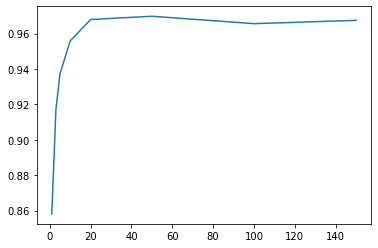

In [20]:
plt.plot(max_lens, test_accuracy)

You may be suprised, that the model achieves nearly a 86% accuracy from just a single word! However, let's take a look at class distribution in a test data

In [21]:
c1 = Counter(y_test)
c1[0]/(c1[0]+c1[1])

0.7910656119125175

If the model guessed always 0, it would achieve a 79% accuracy. Still, it did 6% more, but you see, that you can quickly be trapped into misconception, that 1 word is enough - that is not true. The model favours negative class (ham), even though it did learn some useful words that are good indicators for distinguishing between ham and spam.

Overall, we see that something like 30-40 words would be enough for the model